<a href="https://colab.research.google.com/github/la2015-hw/Group_10/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [10]:
!pip install kaggle --quiet

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mustansireranpurwala/sdss-image-dataset")

print("Path to dataset files:", path)


100%|██████████| 9.48G/9.48G [02:19<00:00, 72.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mustansireranpurwala/sdss-image-dataset/versions/6


In [16]:
import h5py
import numpy as np
import os

# Use the KaggleHub download path
import kagglehub
dataset_path = "/root/.cache/kagglehub/datasets/mustansireranpurwala/sdss-image-dataset/versions/6/processed_sdss_balanced.h5"


print("Path to dataset file:", dataset_path)

# Inspect file
with h5py.File(dataset_path, "r") as f:
    print("Keys in HDF5 file:", list(f.keys()))
    for key in f.keys():
        print(f"{key}: shape={f[key].shape}, dtype={f[key].dtype}")

# Extract features and labels
with h5py.File(dataset_path, "r") as f:
    # Target label
    y = np.array(f["death_status"][:]).astype(str)

    # Features (all photometric + color + positional)
    X = np.column_stack([
        f["u_mag"][:],
        f["g_mag"][:],
        f["r_mag"][:],
        f["i_mag"][:],
        f["z_mag"][:],
        f["u_minus_g"][:],
        f["g_minus_r"][:],
        f["r_minus_i"][:],
        f["i_minus_z"][:],
        f["specz_redshift"][:],
        f["e_bv"][:],
        f["specz_redshift_err"][:],
        f["dec"][:],
        f["ra"][:]
    ])


Path to dataset file: /root/.cache/kagglehub/datasets/mustansireranpurwala/sdss-image-dataset/versions/6/processed_sdss_balanced.h5
Keys in HDF5 file: ['ObjID', 'death_status', 'dec', 'e_bv', 'g_mag', 'g_minus_r', 'gz2class', 'i_mag', 'i_minus_z', 'images', 'r_mag', 'r_minus_i', 'ra', 'specObjID', 'specz_redshift', 'specz_redshift_err', 'u_mag', 'u_minus_g', 'z_mag']
ObjID: shape=(47600,), dtype=|S20
death_status: shape=(47600,), dtype=|S15
dec: shape=(47600,), dtype=float64
e_bv: shape=(47600,), dtype=float32
g_mag: shape=(47600,), dtype=float32
g_minus_r: shape=(47600,), dtype=float32
gz2class: shape=(47600,), dtype=object
i_mag: shape=(47600,), dtype=float32
i_minus_z: shape=(47600,), dtype=float32
images: shape=(47600, 107, 107, 5), dtype=float32
r_mag: shape=(47600,), dtype=float32
r_minus_i: shape=(47600,), dtype=float32
ra: shape=(47600,), dtype=float64
specObjID: shape=(47600,), dtype=int64
specz_redshift: shape=(47600,), dtype=float32
specz_redshift_err: shape=(47600,), dtype=

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Label classes:", label_encoder.classes_)

# Train-test split (80 % / 20 %)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Normalize features for stable training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Label classes: ['ALIVE' 'DEAD' 'TRANSITIONAL']


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Model 1: 256-128-64 ---
def build_mlp_1(input_dim, n_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    return model

# --- Model 2: 512-256-128 ---
def build_mlp_2(input_dim, n_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    return model

# --- Model 3: 128-64 ---
def build_mlp_3(input_dim, n_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    return model


In [19]:
def run_experiment(build_fn, lr=1e-4, epochs=30, run_name='experiment'):
    model = build_fn(X_train.shape[1], len(np.unique(y_encoded)))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f"{run_name}_best.h5", monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    best_epoch = int(np.argmax(history.history['val_accuracy']))
    print(f"\n✅ Best epoch: {best_epoch+1}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    return model, history


In [20]:
model_1, hist_1 = run_experiment(build_mlp_1, run_name='mlp_256_128_64')
model_2, hist_2 = run_experiment(build_mlp_2, run_name='mlp_512_256_128')
model_3, hist_3 = run_experiment(build_mlp_3, run_name='mlp_128_64')


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5930 - loss: 0.9335

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5941 - loss: 0.9321 - val_accuracy: 0.7384 - val_loss: 0.6028 - learning_rate: 1.0000e-04
Epoch 2/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7593 - loss: 0.5903

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7593 - loss: 0.5901 - val_accuracy: 0.8395 - val_loss: 0.4399 - learning_rate: 1.0000e-04
Epoch 3/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8005 - loss: 0.4750

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8006 - loss: 0.4748 - val_accuracy: 0.8642 - val_loss: 0.3702 - learning_rate: 1.0000e-04
Epoch 4/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8205 - loss: 0.4211

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8205 - loss: 0.4211 - val_accuracy: 0.8787 - val_loss: 0.3396 - learning_rate: 1.0000e-04
Epoch 5/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8304 - loss: 0.3934

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8305 - loss: 0.3931 - val_accuracy: 0.8879 - val_loss: 0.3109 - learning_rate: 1.0000e-04
Epoch 6/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8428 - loss: 0.3667

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8428 - loss: 0.3667 - val_accuracy: 0.8913 - val_loss: 0.2891 - learning_rate: 1.0000e-04
Epoch 7/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8531 - loss: 0.3452

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8532 - loss: 0.3451 - val_accuracy: 0.8965 - val_loss: 0.2698 - learning_rate: 1.0000e-04
Epoch 8/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8624 - loss: 0.3215

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8624 - loss: 0.3215 - val_accuracy: 0.8981 - val_loss: 0.2527 - learning_rate: 1.0000e-04
Epoch 9/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8626 - loss: 0.3168

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8626 - loss: 0.3168 - val_accuracy: 0.9062 - val_loss: 0.2330 - learning_rate: 1.0000e-04
Epoch 10/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8707 - loss: 0.2921

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8707 - loss: 0.2921 - val_accuracy: 0.9107 - val_loss: 0.2185 - learning_rate: 1.0000e-04
Epoch 11/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8769 - loss: 0.2808

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8769 - loss: 0.2807 - val_accuracy: 0.9196 - val_loss: 0.2020 - learning_rate: 1.0000e-04
Epoch 12/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8850 - loss: 0.2774

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8850 - loss: 0.2773 - val_accuracy: 0.9207 - val_loss: 0.1975 - learning_rate: 1.0000e-04
Epoch 13/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8879 - loss: 0.2577

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8879 - loss: 0.2577 - val_accuracy: 0.9262 - val_loss: 0.1840 - learning_rate: 1.0000e-04
Epoch 14/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8938 - loss: 0.2529

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8939 - loss: 0.2528 - val_accuracy: 0.9343 - val_loss: 0.1735 - learning_rate: 1.0000e-04
Epoch 15/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9018 - loss: 0.2347

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9018 - loss: 0.2346 - val_accuracy: 0.9372 - val_loss: 0.1640 - learning_rate: 1.0000e-04
Epoch 16/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9012 - loss: 0.2289

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9012 - loss: 0.2288 - val_accuracy: 0.9399 - val_loss: 0.1606 - learning_rate: 1.0000e-04
Epoch 17/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9119 - loss: 0.2136

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9118 - loss: 0.2136 - val_accuracy: 0.9441 - val_loss: 0.1467 - learning_rate: 1.0000e-04
Epoch 18/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9158 - loss: 0.2069

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9158 - loss: 0.2068 - val_accuracy: 0.9485 - val_loss: 0.1448 - learning_rate: 1.0000e-04
Epoch 19/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9159 - loss: 0.2024

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9160 - loss: 0.2022 - val_accuracy: 0.9561 - val_loss: 0.1243 - learning_rate: 1.0000e-04
Epoch 20/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - loss: 0.1826

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9235 - loss: 0.1827 - val_accuracy: 0.9588 - val_loss: 0.1137 - learning_rate: 1.0000e-04
Epoch 21/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9275 - loss: 0.1826

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9276 - loss: 0.1826 - val_accuracy: 0.9603 - val_loss: 0.1070 - learning_rate: 1.0000e-04
Epoch 22/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9294 - loss: 0.1752

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9295 - loss: 0.1751 - val_accuracy: 0.9674 - val_loss: 0.0969 - learning_rate: 1.0000e-04
Epoch 23/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9311 - loss: 0.1682

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9312 - loss: 0.1680 - val_accuracy: 0.9661 - val_loss: 0.0937 - learning_rate: 1.0000e-04
Epoch 24/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9368 - loss: 0.1546

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9368 - loss: 0.1546 - val_accuracy: 0.9703 - val_loss: 0.0879 - learning_rate: 1.0000e-04
Epoch 25/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9384 - loss: 0.1505

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9383 - loss: 0.1505 - val_accuracy: 0.9727 - val_loss: 0.0828 - learning_rate: 1.0000e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9422 - loss: 0.1434 - val_accuracy: 0.9695 - val_loss: 0.0833 - learning_rate: 1.0000e-04
Epoch 27/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9402 - loss: 0.1489

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9403 - loss: 0.1486 - val_accuracy: 0.9730 - val_loss: 0.0765 - learning_rate: 1.0000e-04
Epoch 28/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9471 - loss: 0.1304

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9470 - loss: 0.1306 - val_accuracy: 0.9756 - val_loss: 0.0703 - learning_rate: 1.0000e-04
Epoch 29/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9485 - loss: 0.1289

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9485 - loss: 0.1289 - val_accuracy: 0.9737 - val_loss: 0.0696 - learning_rate: 1.0000e-04
Epoch 30/30
258/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9477 - loss: 0.1311

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9477 - loss: 0.1309 - val_accuracy: 0.9753 - val_loss: 0.0677 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.

✅ Best epoch: 28
Final Training Accuracy: 0.9484
Final Validation Accuracy: 0.9753
Epoch 1/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6902 - loss: 0.7935

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6905 - loss: 0.7925 - val_accuracy: 0.8283 - val_loss: 0.4347 - learning_rate: 1.0000e-04
Epoch 2/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8132 - loss: 0.4469

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8134 - loss: 0.4465 - val_accuracy: 0.8776 - val_loss: 0.3437 - learning_rate: 1.0000e-04
Epoch 3/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8425 - loss: 0.3749

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8426 - loss: 0.3746 - val_accuracy: 0.8892 - val_loss: 0.2945 - learning_rate: 1.0000e-04
Epoch 4/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8599 - loss: 0.3311

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8600 - loss: 0.3309 - val_accuracy: 0.9047 - val_loss: 0.2526 - learning_rate: 1.0000e-04
Epoch 5/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8712 - loss: 0.2991

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8712 - loss: 0.2991 - val_accuracy: 0.9115 - val_loss: 0.2311 - learning_rate: 1.0000e-04
Epoch 6/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8883 - loss: 0.2638

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8884 - loss: 0.2638 - val_accuracy: 0.9215 - val_loss: 0.2062 - learning_rate: 1.0000e-04
Epoch 7/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8973 - loss: 0.2487

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8973 - loss: 0.2487 - val_accuracy: 0.9202 - val_loss: 0.2030 - learning_rate: 1.0000e-04
Epoch 8/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9014 - loss: 0.2296

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9014 - loss: 0.2296 - val_accuracy: 0.9336 - val_loss: 0.1737 - learning_rate: 1.0000e-04
Epoch 9/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9095 - loss: 0.2145

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9095 - loss: 0.2144 - val_accuracy: 0.9435 - val_loss: 0.1486 - learning_rate: 1.0000e-04
Epoch 10/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9177 - loss: 0.2035

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9177 - loss: 0.2034 - val_accuracy: 0.9491 - val_loss: 0.1374 - learning_rate: 1.0000e-04
Epoch 11/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9236 - loss: 0.1825

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9236 - loss: 0.1825 - val_accuracy: 0.9546 - val_loss: 0.1202 - learning_rate: 1.0000e-04
Epoch 12/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9284 - loss: 0.1738

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9284 - loss: 0.1738 - val_accuracy: 0.9548 - val_loss: 0.1170 - learning_rate: 1.0000e-04
Epoch 13/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9314 - loss: 0.1623

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9315 - loss: 0.1623 - val_accuracy: 0.9648 - val_loss: 0.0982 - learning_rate: 1.0000e-04
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9375 - loss: 0.1535 - val_accuracy: 0.9624 - val_loss: 0.1000 - learning_rate: 1.0000e-04
Epoch 15/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9428 - loss: 0.1407 - val_accuracy: 0.9651 - val_loss: 0.1086 - learning_rate: 1.0000e-04
Epoch 16/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9431 - loss: 0.1439

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9432 - loss: 0.1437 - val_accuracy: 0.9724 - val_loss: 0.0782 - learning_rate: 1.0000e-04
Epoch 17/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9474 - loss: 0.1292

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9474 - loss: 0.1292 - val_accuracy: 0.9703 - val_loss: 0.0773 - learning_rate: 1.0000e-04
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9527 - loss: 0.1199 - val_accuracy: 0.9751 - val_loss: 0.0824 - learning_rate: 1.0000e-04
Epoch 19/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9528 - loss: 0.1216

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9528 - loss: 0.1215 - val_accuracy: 0.9782 - val_loss: 0.0662 - learning_rate: 1.0000e-04
Epoch 20/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9546 - loss: 0.1143 - val_accuracy: 0.9751 - val_loss: 0.0679 - learning_rate: 1.0000e-04
Epoch 21/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9562 - loss: 0.1108

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9561 - loss: 0.1108 - val_accuracy: 0.9753 - val_loss: 0.0655 - learning_rate: 1.0000e-04
Epoch 22/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9567 - loss: 0.1040

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9567 - loss: 0.1040 - val_accuracy: 0.9769 - val_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 23/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9615 - loss: 0.0988

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9615 - loss: 0.0988 - val_accuracy: 0.9800 - val_loss: 0.0582 - learning_rate: 1.0000e-04
Epoch 24/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9580 - loss: 0.1049

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9580 - loss: 0.1049 - val_accuracy: 0.9769 - val_loss: 0.0579 - learning_rate: 1.0000e-04
Epoch 25/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9593 - loss: 0.1002

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9593 - loss: 0.1001 - val_accuracy: 0.9795 - val_loss: 0.0524 - learning_rate: 1.0000e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9625 - loss: 0.0927 - val_accuracy: 0.9782 - val_loss: 0.0547 - learning_rate: 1.0000e-04
Epoch 27/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9652 - loss: 0.0883

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9652 - loss: 0.0883 - val_accuracy: 0.9835 - val_loss: 0.0478 - learning_rate: 1.0000e-04
Epoch 28/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9652 - loss: 0.0921 - val_accuracy: 0.9774 - val_loss: 0.0521 - learning_rate: 1.0000e-04
Epoch 29/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9660 - loss: 0.0847 - val_accuracy: 0.9819 - val_loss: 0.0484 - learning_rate: 1.0000e-04
Epoch 30/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9667 - loss: 0.0838
Epoch 30: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9667 - loss: 0.0838 - val_accuracy: 0.9800 - val_loss: 0.0478 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 27.

✅ Best epoch: 27
Final Training Accuracy: 0.9673
Final Validation Accuracy: 0.9800
Epoch 1/30
253/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6297 - loss: 0.925

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6334 - loss: 0.9205 - val_accuracy: 0.7298 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 2/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7378 - loss: 0.6953

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7379 - loss: 0.6950 - val_accuracy: 0.7639 - val_loss: 0.5625 - learning_rate: 1.0000e-04
Epoch 3/30
251/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7639 - loss: 0.5853

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7643 - loss: 0.5841 - val_accuracy: 0.8049 - val_loss: 0.4866 - learning_rate: 1.0000e-04
Epoch 4/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7807 - loss: 0.5230

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7809 - loss: 0.5226 - val_accuracy: 0.8301 - val_loss: 0.4387 - learning_rate: 1.0000e-04
Epoch 5/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8009 - loss: 0.4825

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8010 - loss: 0.4819 - val_accuracy: 0.8443 - val_loss: 0.4040 - learning_rate: 1.0000e-04
Epoch 6/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8169 - loss: 0.4350

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8169 - loss: 0.4350 - val_accuracy: 0.8606 - val_loss: 0.3731 - learning_rate: 1.0000e-04
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8265 - loss: 0.4284

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8266 - loss: 0.4284 - val_accuracy: 0.8732 - val_loss: 0.3496 - learning_rate: 1.0000e-04
Epoch 8/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8352 - loss: 0.4052

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8352 - loss: 0.4049 - val_accuracy: 0.8779 - val_loss: 0.3296 - learning_rate: 1.0000e-04
Epoch 9/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8467 - loss: 0.3686

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8467 - loss: 0.3685 - val_accuracy: 0.8897 - val_loss: 0.3163 - learning_rate: 1.0000e-04
Epoch 10/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8568 - loss: 0.3524

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8567 - loss: 0.3524 - val_accuracy: 0.8931 - val_loss: 0.2994 - learning_rate: 1.0000e-04
Epoch 11/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8547 - loss: 0.3384

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8547 - loss: 0.3384 - val_accuracy: 0.8955 - val_loss: 0.2790 - learning_rate: 1.0000e-04
Epoch 12/30
253/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8612 - loss: 0.3348

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8614 - loss: 0.3345 - val_accuracy: 0.9020 - val_loss: 0.2715 - learning_rate: 1.0000e-04
Epoch 13/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8706 - loss: 0.3141

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8707 - loss: 0.3140 - val_accuracy: 0.9062 - val_loss: 0.2557 - learning_rate: 1.0000e-04
Epoch 14/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8772 - loss: 0.3014

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8771 - loss: 0.3015 - val_accuracy: 0.9091 - val_loss: 0.2466 - learning_rate: 1.0000e-04
Epoch 15/30
253/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8757 - loss: 0.2949

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8758 - loss: 0.2950 - val_accuracy: 0.9123 - val_loss: 0.2359 - learning_rate: 1.0000e-04
Epoch 16/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8808 - loss: 0.2846

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8809 - loss: 0.2845 - val_accuracy: 0.9181 - val_loss: 0.2252 - learning_rate: 1.0000e-04
Epoch 17/30
252/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8855 - loss: 0.2766

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8856 - loss: 0.2765 - val_accuracy: 0.9199 - val_loss: 0.2159 - learning_rate: 1.0000e-04
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8886 - loss: 0.2732

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8886 - loss: 0.2732 - val_accuracy: 0.9228 - val_loss: 0.2068 - learning_rate: 1.0000e-04
Epoch 19/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8938 - loss: 0.2550

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8938 - loss: 0.2550 - val_accuracy: 0.9246 - val_loss: 0.2023 - learning_rate: 1.0000e-04
Epoch 20/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8949 - loss: 0.2572

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8950 - loss: 0.2569 - val_accuracy: 0.9288 - val_loss: 0.1956 - learning_rate: 1.0000e-04
Epoch 21/30
250/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8986 - loss: 0.2447

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8986 - loss: 0.2449 - val_accuracy: 0.9328 - val_loss: 0.1866 - learning_rate: 1.0000e-04
Epoch 22/30
254/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9027 - loss: 0.2357

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9028 - loss: 0.2357 - val_accuracy: 0.9346 - val_loss: 0.1785 - learning_rate: 1.0000e-04
Epoch 23/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9048 - loss: 0.2312

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9048 - loss: 0.2312 - val_accuracy: 0.9383 - val_loss: 0.1735 - learning_rate: 1.0000e-04
Epoch 24/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9075 - loss: 0.2256

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9075 - loss: 0.2256 - val_accuracy: 0.9417 - val_loss: 0.1690 - learning_rate: 1.0000e-04
Epoch 25/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9120 - loss: 0.2103

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9120 - loss: 0.2104 - val_accuracy: 0.9456 - val_loss: 0.1594 - learning_rate: 1.0000e-04
Epoch 26/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9155 - loss: 0.2102

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9155 - loss: 0.2102 - val_accuracy: 0.9480 - val_loss: 0.1542 - learning_rate: 1.0000e-04
Epoch 27/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9197 - loss: 0.2053

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9196 - loss: 0.2054 - val_accuracy: 0.9501 - val_loss: 0.1461 - learning_rate: 1.0000e-04
Epoch 28/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9218 - loss: 0.1939

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9217 - loss: 0.1941 - val_accuracy: 0.9506 - val_loss: 0.1455 - learning_rate: 1.0000e-04
Epoch 29/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9243 - loss: 0.1911

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9243 - loss: 0.1911 - val_accuracy: 0.9564 - val_loss: 0.1347 - learning_rate: 1.0000e-04
Epoch 30/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9249 - loss: 0.1858

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9249 - loss: 0.1858 - val_accuracy: 0.9567 - val_loss: 0.1313 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.

✅ Best epoch: 30
Final Training Accuracy: 0.9249
Final Validation Accuracy: 0.9567


298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9834 - loss: 0.0503
Test Accuracy: 0.9836 | Test Loss: 0.0497
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

       ALIVE       0.97      0.98      0.97      1097
        DEAD       0.95      0.99      0.97      1473
TRANSITIONAL       0.99      0.98      0.99      6950

    accuracy                           0.98      9520
   macro avg       0.97      0.98      0.98      9520
weighted avg       0.98      0.98      0.98      9520



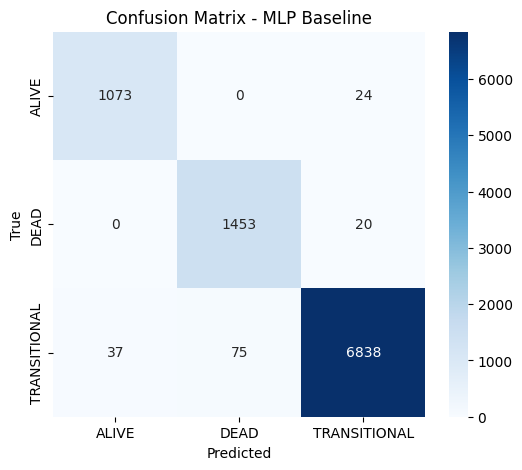

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test data
test_loss, test_acc = model_2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Predictions
y_pred = np.argmax(model_2.predict(X_test), axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues')
plt.title("Confusion Matrix - MLP Baseline")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
